In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

!ln -s /content/gdrive/MyDrive /mydrive

Mounted at /content/gdrive/


In [ ]:
!pip install pyspark

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import round as RD

In [ ]:
#Create spark session
spark = SparkSession.builder.appName('spark').getOrCreate()

#Reading data
df_pyspark = spark.read.csv('/mydrive/COVID-19.csv',header=True, inferSchema=True)

#Drop na
df_pyspark = df_pyspark.dropna(how="any")

#First transformation
df_male = df_pyspark.filter((df_pyspark['Location']=='AK') & (df_pyspark['Demographic_Category']=='Sex_Male'))
df_female = df_pyspark.filter((df_pyspark['Location']=='AK') & (df_pyspark['Demographic_Category']=='Sex_Female'))
df_sex= df_male.union(df_female).withColumnRenamed('Demographic_Category', 'Sex')

#Second transformation
df_sex_trans=df_sex.withColumn('Booster_Dose_pct_Sex', RD((df_sex['Booster_Doses']/df_sex['census'])*100,1))


#Quries
df_sex_trans.registerTempTable('AlaskaTable')
sqlContext = SQLContext(spark)

df_query1 = sqlContext.sql("SELECT Date, Sex, Booster_Dose_pct_Sex from AlaskaTable")
df_query2_female = sqlContext.sql("SELECT Date, Sex, Series_Complete_Yes from AlaskaTable where Sex == 'Sex_Female'")
df_query2_male = sqlContext.sql("SELECT Date, Sex, Series_Complete_Yes from AlaskaTable where Sex == 'Sex_Male'")

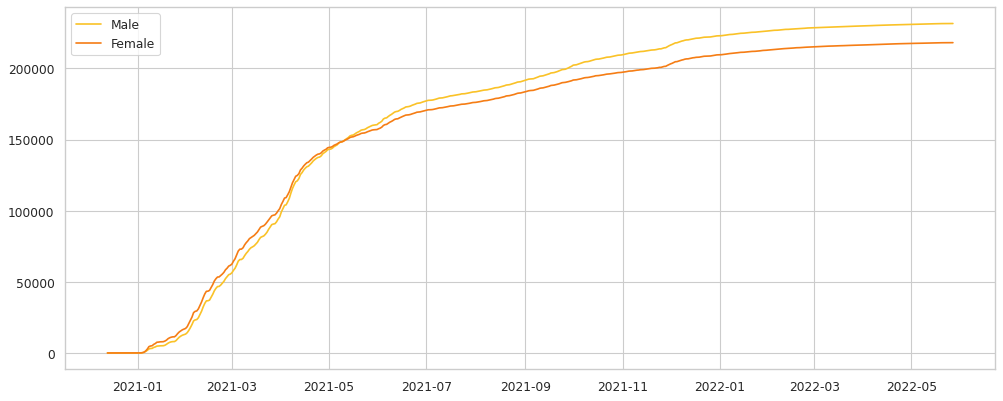

In [ ]:
#Plot the results
sns.set_theme(style='whitegrid', palette='inferno_r')

df_query2_male = df_query2_male.toPandas()
df_query2_female = df_query2_female.toPandas()

df_query2_male['Date'] = pd.to_datetime(df_query2_male['Date'])
df_query2_female['Date'] = pd.to_datetime(df_query2_female['Date'])

plt.figure(figsize=(15,6), dpi=80)

plt.plot(df_query2_male['Date'], df_query2_male['Series_Complete_Yes'])

plt.plot(df_query2_female['Date'], df_query2_female['Series_Complete_Yes'])

plt.legend(['Male', 'Female'])

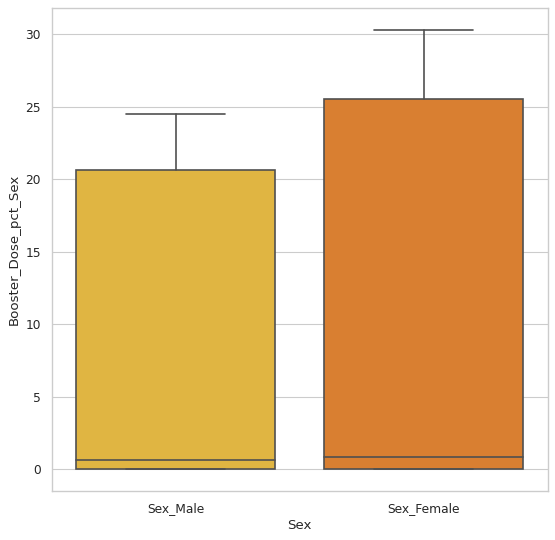

In [ ]:
#Convert to pandas
df_query1 = df_query1.toPandas()
plt.figure(figsize=(8,8), dpi=80)
sns.boxplot(x="Sex", y="Booster_Dose_pct_Sex", data=df_query1)